# **Capstone Project - *IllDetect*: Cardiovascular Diagnosis Detector** <br>
ID Tim: CC25-CF225  <br>
Anggota Tim:  
1. (ML) MC008D5X2348 - Marsha Rasyida Al-Farabi
2. (ML) MC008D5X2087 - Syifa Azzahra Susilo
3. (ML) MC008D5X2388 - Indara Nurwulandari
4. (FEBE) FC492D5Y2169 - Muhammad Novian
5. (FEBE) FC179D5Y0593- Muh Diaz Nazarudin Rahman
6. (FEBE) FC179D5Y1055 - Aditya Navra Erlangga <br>

Tema: Health Innovation

*IllDetect – Cardiovascular Diagnosis Detector* merupakan inovasi digital yang bertujuan membantu masyarakat mendeteksi risiko penyakit jantung secara mandiri, cepat, dan mudah.

Library yang dibutuhkan pada proyek ini sebagai berikut:

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import kagglehub
import os
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

## **Data Understanding** <br>

Dataset yang digunakan dalam proyek ini berasal dari platform Kaggle dengan judul “Cardiovascular Disease Dataset”. Dataset ini digunakan untuk membangun model prediktif dalam mendeteksi risiko penyakit jantung berdasarkan berbagai parameter klinis dan gaya hidup. Link dataset : 🔗 https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset

Dataset asli berisi 70.000 observasi dengan 13 kolom, namun dalam proyek ini, tim kami memilih 10.000 data secara acak menggunakan parameter `random_state` untuk dijadikan sebagai dataset utama.

Pemilihan subset ini dilakukan dengan pertimbangan:
- **Efisiensi waktu komputasi**, agar pemodelan dan evaluasi dapat dilakukan secara optimal tanpa mengorbankan performa model.
- **Reduksi kompleksitas dan outlier**, untuk menghindari noise atau data ekstrem yang dapat mengganggu kualitas pelatihan.
- **Representativitas tetap terjaga**, karena pengambilan dilakukan secara acak dan stratifikasi tidak diperlukan.

Seluruh tahap mulai dari EDA, data preparation, modeling, serta evaluation dilakukan menggunakan 10.000 observasi terpilih ini.

Berikut adalah penjelasan mengenai variabel-variabel pada dataset tersebut:
- `id`: ID unik yang mengacu pada masing-masing pasien dalam dataset.
- `age`: Usia pasien dalam satuan hari.
- `gender`: Jenis kelamin pasien, di mana 1 = perempuan dan 2 = laki-laki.
- `height`: Tinggi badan pasien (cm)
- `weight`: Berat badan pasien (kg).
- `ap_hi`: Tekanan darah sistolik pasien (angka atas).
- `ap_lo`: Tekanan darah diastolik pasien (angka bawah).
- `cholesterol`: Kategori tingkat kolesterol, dengan nilai 1 = normal, 2 = di atas normal, dan 3 = jauh di atas normal.
- `gluc`: Kategori tingkat glukosa darah, dengan nilai 1 = normal, 2 = di atas normal, dan 3 = jauh di atas normal.
- `smoke`: Status merokok pasien, di mana 0 = tidak merokok dan 1 = merokok.
- `alco`: Konsumsi alkohol oleh pasien, dengan nilai 0 = tidak mengonsumsi dan 1 = mengonsumsi alkohol.
- `active`: Tingkat aktivitas fisik pasien, dengan nilai 0 = tidak aktif dan 1 = aktif secara fisik.
- `cardio`: Label target yang menunjukkan apakah pasien menderita penyakit kardiovaskular, dengan nilai 0 = tidak dan 1 = ya.

In [36]:
# Download datasets dari Kaggle
path = kagglehub.dataset_download("sulianova/cardiovascular-disease-dataset")

In [37]:
# Membaca file CSV ke dalam DataFrame
df = pd.read_csv(os.path.join(path, 'cardio_train.csv'), sep=';')
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [38]:
# Mengambil 10000 data secara acak
df = df.sample(n=10000, random_state=42)
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
46730,66728,21770,1,156,64.0,140,80,2,1,0,0,1,1
48393,69098,21876,1,170,85.0,160,90,1,1,0,0,1,1
41416,59185,23270,1,151,90.0,130,80,1,1,0,0,1,1
34506,49288,19741,1,159,97.0,120,80,1,1,0,0,1,1
43725,62481,18395,1,164,68.0,120,80,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20679,29516,19523,1,157,61.0,120,80,1,1,0,0,1,0
48140,68751,18397,1,157,79.0,145,90,2,1,0,0,1,1
59195,84523,15213,1,156,70.0,100,70,1,1,0,0,1,0
12633,18032,20504,1,158,57.0,120,70,1,1,0,0,1,0


In [39]:
# Informasi jumlah row dan column
df.shape

(10000, 13)

Dataset terdiri dari 10000 data dan 13 kolom variabel.

In [40]:
# Informasi kolom pada dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 46730 to 39641
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           10000 non-null  int64  
 1   age          10000 non-null  int64  
 2   gender       10000 non-null  int64  
 3   height       10000 non-null  int64  
 4   weight       10000 non-null  float64
 5   ap_hi        10000 non-null  int64  
 6   ap_lo        10000 non-null  int64  
 7   cholesterol  10000 non-null  int64  
 8   gluc         10000 non-null  int64  
 9   smoke        10000 non-null  int64  
 10  alco         10000 non-null  int64  
 11  active       10000 non-null  int64  
 12  cardio       10000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 1.1 MB


 Semua kolom memiliki 10000 entri yang lengkap (non-null), sehingga tidak terdapat missing value. Semua tipe data kolom adalah numerik.

In [41]:
# Informasi rata-rata, std, min, max, dll pada dataset
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,49849.610200,19477.445200,1.354700,164.483200,74.261867,128.631000,93.698800,1.373500,1.234600,0.087200,0.049900,0.802400,0.503600
std,28741.069831,2467.753159,0.478446,8.347975,14.494832,161.476124,131.750461,0.685744,0.584634,0.282142,0.217749,0.398209,0.500012
min,4.000000,14282.000000,1.000000,57.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,24792.500000,17657.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50344.000000,19719.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,74297.750000,21329.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99963.000000,23692.000000,2.000000,198.000000,183.000000,16020.000000,8099.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Berdasarkan statistik deskriptif, usia pasien berkisar antara 39 hingga 65 tahun. Rata-rata tinggi badan 164 cm dan berat badan 74 kg, dengan beberapa pasien mengalami obesitas. Tekanan darah menunjukkan adanya nilai ekstrem yang tidak wajar, sehingga perlu dilakukan pembersihan data. Mayoritas pasien memiliki kolesterol dan glukosa normal hingga sedikit tinggi, tidak merokok, tidak mengonsumsi alkohol, dan aktif secara fisik. Sekitar 50% pasien menderita penyakit kardiovaskular.

## **Exploratory Data Analysis** <br>


**1. Berapa rentang usia pasien dalam dataset?**

pada dataset ini, kolom `age` disimpan dalam satuan hari, maka dikonversi ke tahun.

In [42]:
# Konversi usia ke tahun
df['age_years'] = (df['age'] / 365).astype(int)
usia_min = df['age_years'].min()
usia_max = df['age_years'].max()
print(f"Rentang usia pasien: {usia_min} - {usia_max} tahun")

Rentang usia pasien: 39 - 64 tahun


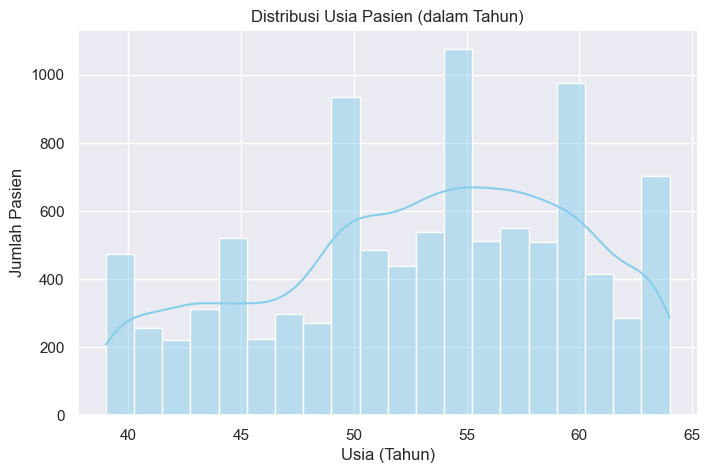

In [43]:
plt.figure(figsize=(8, 5))
sns.histplot(df["age_years"], bins=20, kde=True, color='skyblue')
plt.title("Distribusi Usia Pasien (dalam Tahun)")
plt.xlabel("Usia (Tahun)")
plt.ylabel("Jumlah Pasien")
plt.grid(True)
plt.show()

Distribusi usia pasien menunjukkan bahwa sebagian besar pasien berada dalam rentang usia 39–64 tahun. Hal ini mengindikasikan bahwa penyakit kardiovaskular dalam dataset ini lebih banyak terjadi pada kelompok usia paruh baya hingga lanjut usia.

**2. Berapa banyak pria dan wanita yang terwakili dalam dataset?**

In [44]:
gender_count = df['gender'].value_counts()
gender_count.index = ['Perempuan', 'Laki-laki']
print(gender_count)

Perempuan    6453
Laki-laki    3547
Name: count, dtype: int64


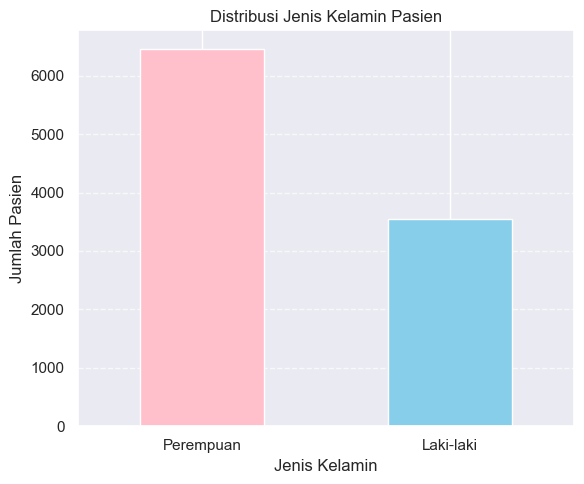

In [45]:
plt.figure(figsize=(6, 5))
colors = ['pink', 'skyblue']
gender_count.plot(kind='bar', color=colors)
plt.title("Distribusi Jenis Kelamin Pasien")
plt.xlabel("Jenis Kelamin")
plt.ylabel("Jumlah Pasien")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Jumlah pasien perempuan lebih banyak dibandingkan laki-laki, dengan 6.453 perempuan dan 3.547 laki-laki. Hal ini menunjukkan representasi pasien perempuan hampir dua kali lipat dari pasien laki-laki.

**3. Berapa tekanan darah rata-rata pasien?**

In [46]:
mean_sys = df['ap_hi'].mean()
mean_dia = df['ap_lo'].mean()
print(f"Tekanan darah rata-rata: {mean_sys:.2f}/{mean_dia:.2f} mmHg")

Tekanan darah rata-rata: 128.63/93.70 mmHg


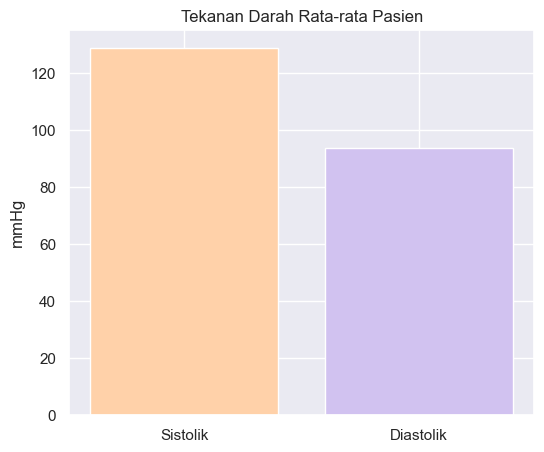

In [47]:
plt.figure(figsize=(6, 5))
mean_ap_hi = df["ap_hi"].mean()
mean_ap_lo = df["ap_lo"].mean()
plt.bar(["Sistolik", "Diastolik"], [mean_ap_hi, mean_ap_lo], color=['#FFD1A9', '#D1C2F0'])
plt.title("Tekanan Darah Rata-rata Pasien")
plt.ylabel("mmHg")
plt.show()

Tekanan darah rata-rata pasien dalam dataset adalah 128.63 mmHg untuk sistolik dan 93.70 mmHg untuk diastolik. Nilai ini menunjukkan bahwa rata-rata pasien memiliki tekanan darah yang cenderung tinggi, mendekati atau melebihi batas normal.

**4. Berapa persen pasian yang memiliki gula darah lebih dari 120 mg/dl??**


In [48]:
glukosa = df[df['gluc'] > 1].shape[0]
persen = (glukosa / len(df)) * 100
print(f"{persen:.2f}% pasien memiliki kadar glukosa lebih dari 120 mg/dL.")

15.35% pasien memiliki kadar glukosa lebih dari 120 mg/dL.


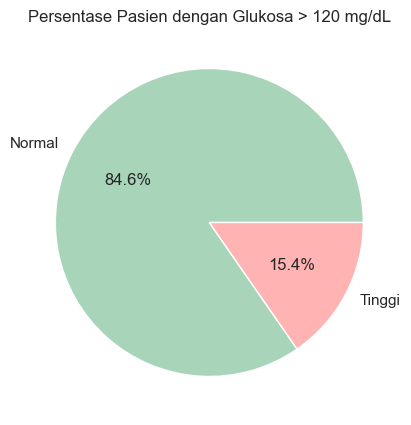

In [49]:
df["gluc_level"] = df["gluc"].apply(lambda x: "Normal" if x == 1 else "Tinggi")
gluc_counts = df["gluc_level"].value_counts()

plt.figure(figsize=(6, 5))
plt.pie(gluc_counts, labels=gluc_counts.index, autopct='%1.1f%%', colors=['#A8D5BA', '#FFB3B3'])
plt.title("Persentase Pasien dengan Glukosa > 120 mg/dL")
plt.show()

Sebanyak 15,35% pasien dalam dataset memiliki kadar glukosa darah lebih dari 120 mg/dL, menunjukkan bahwa sebagian pasien berisiko mengalami gangguan gula darah atau diabetes. Visualisasi pie chart di atas menunjukkan perbandingan jelas antara pasien dengan kadar glukosa normal dan tinggi.

**5. Bagaimana distribusi tingkat kolesterol pasien dalam dataset, dan berapa persen pasien yang memiliki kolesterol di atas normal?**

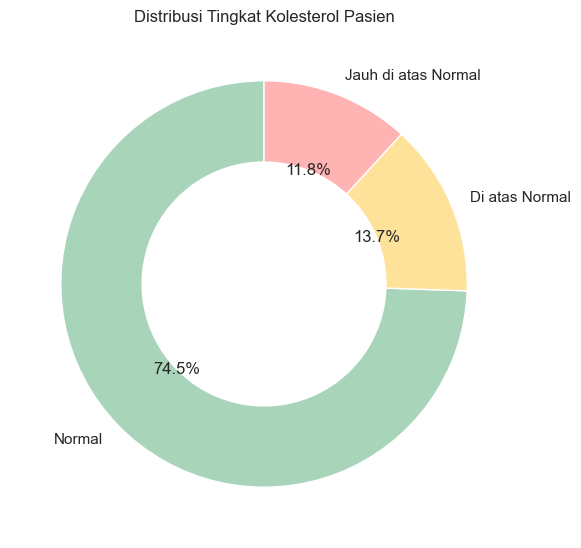

In [50]:
chol_counts = df['cholesterol'].value_counts()
label_mapping = {
    1: 'Normal',
    2: 'Di atas Normal',
    3: 'Jauh di atas Normal'
}

labels = [label_mapping[i] for i in chol_counts.index]
colors = ['#A8D5BA', '#FFE29A', '#FFB3B3']

plt.figure(figsize=(6,6))
plt.pie(chol_counts, labels=labels, autopct='%1.1f%%', startangle=90,
        colors=colors, wedgeprops={'width': 0.4})
plt.title('Distribusi Tingkat Kolesterol Pasien')
plt.tight_layout()
plt.show()

Sebagian besar pasien, yaitu 74,5%, memiliki kadar kolesterol normal. Namun, terdapat 13,7% pasien dengan kolesterol di atas normal dan 11,8% dengan kadar kolesterol jauh di atas normal, menunjukkan adanya risiko kesehatan yang perlu diperhatikan pada sekitar 25% pasien. Visualisasi pie chart di atas menunjukkan proporsi tiap kategori kolesterol dengan jelas.

**6. Bagaimana distribusi berat badan pasien?**

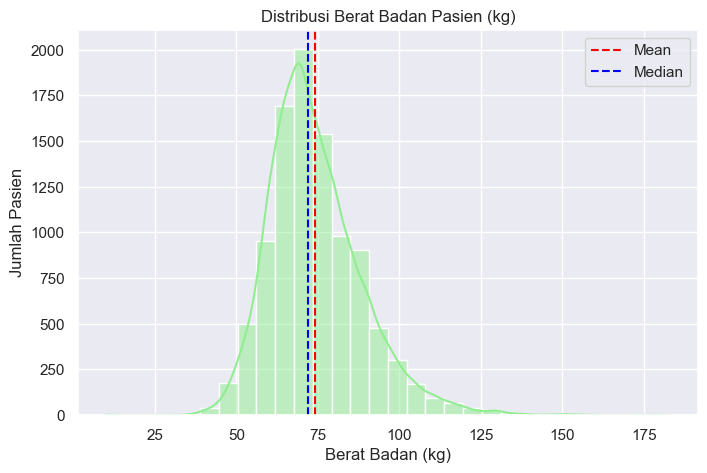

In [51]:
plt.figure(figsize=(8,5))
sns.histplot(df['weight'], bins=30, kde=True, color='lightgreen')
plt.title("Distribusi Berat Badan Pasien (kg)")
plt.xlabel("Berat Badan (kg)")
plt.ylabel("Jumlah Pasien")
plt.axvline(df['weight'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(df['weight'].median(), color='blue', linestyle='--', label='Median')
plt.legend()
plt.grid(True)
plt.show()


Terlihat bahwa distribusi berat badan cenderung tidak simetris (skew ke kanan), dengan adanya "ekor" di sisi kanan, menunjukkan bahwa ada beberapa pasien yang memiliki berat badan yang jauh lebih tinggi dibandingkan mayoritas pasien. Garis mean dan median menunjukkan bahwa mayoritas dan rata-rata subjek berusia sekitar 75 tahun.

**7. Bagaimana korelasi setiap variabel numerik terhadap kardiovaskular?**

Korelasi tiap variabel dengan target 'cardio':
age_years      0.239977
cholesterol    0.230440
weight         0.194229
gluc           0.080930
ap_lo          0.080352
ap_hi          0.053436
alco           0.016262
gender        -0.003039
height        -0.006215
smoke         -0.009315
active        -0.045149
dtype: float64


/var/folders/m2/f0dmk8qn71593x9d7n6nlxl00000gn/T/ipykernel_3176/3916782350.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='viridis')


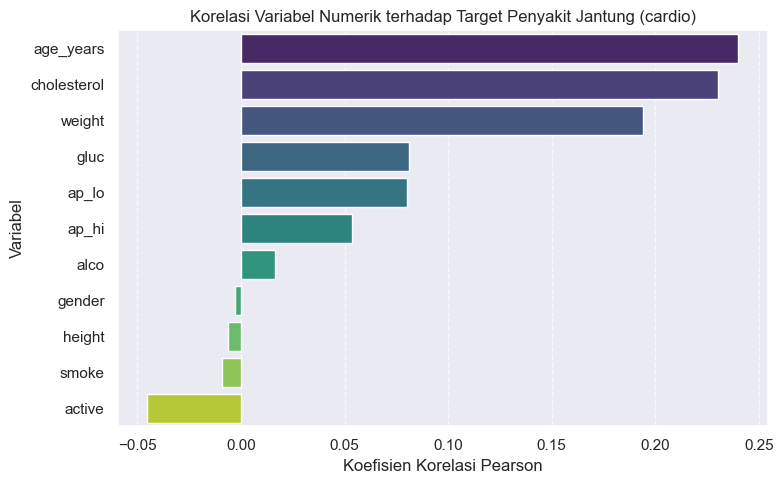

In [52]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(['cardio', 'age', 'id'])

correlations = df[num_cols].corrwith(df['cardio']).sort_values(ascending=False)

print("Korelasi tiap variabel dengan target 'cardio':")
print(correlations)

plt.figure(figsize=(8,5))
sns.barplot(x=correlations.values, y=correlations.index, palette='viridis')
plt.title("Korelasi Variabel Numerik terhadap Target Penyakit Jantung (cardio)")
plt.xlabel("Koefisien Korelasi Pearson")
plt.ylabel("Variabel")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Variabel yang paling berkorelasi dengan penyakit kardiovaskular adalah usia pasien (`age_years`), diikuti oleh kadar kolesterol (`cholestrol`) dan berat badan (`weight`) secara berturut-turut. Ketiga variabel ini menunjukkan hubungan positif, artinya semakin tinggi nilai variabel-variabel tersebut, semakin besar kemungkinan seseorang mengalami penyakit jantung.

Variabel seperti kadar glukosa (`gluc`), tekanan darah (`ap_hi`, `ap_lo`), dan konsumsi alkohol (`alco`) menunjukkan korelasi yang lemah namun masih positif terhadap risiko penyakit. Meskipun korelasinya rendah, tetap ada indikasi kontribusi terhadap kondisi kardiovaskular.

Sementara itu, variabel seperti aktivitas fisik (`active`), merokok (`smoke`), tinggi badan (`height`), dan jenis kelamin (`gender`) memiliki korelasi negatif sangat lemah dengan penyakit kardiovaskular. Hal ini mengindikasikan bahwa hubungan linier langsung antar variabel-variabel tersebut terhadap penyakit tidak terlalu kuat, meskipun tetap bisa berkontribusi secara tidak langsung atau interaktif.

**8. Bagaimana distribusi penyakit berdasarkan gender dan aktivitas fisik?**

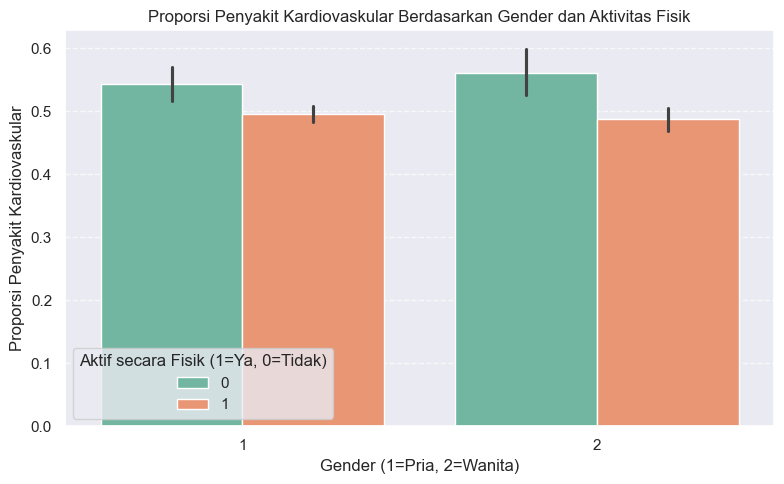

In [53]:
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='gender', y='cardio', hue='active', palette='Set2')
plt.title("Proporsi Penyakit Kardiovaskular Berdasarkan Gender dan Aktivitas Fisik")
plt.xlabel("Gender (1=Pria, 2=Wanita)")
plt.ylabel("Proporsi Penyakit Kardiovaskular")
plt.legend(title="Aktif secara Fisik (1=Ya, 0=Tidak)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Visualisasi ini menunjukkan proporsi penyakit kardiovaskular berdasarkan gender dan aktivitas fisik, di mana baik pada kelompok pria maupun wanita, individu yang tidak aktif secara fisik cenderung memiliki proporsi penyakit kardiovaskular yang lebih tinggi dibandingkan dengan mereka yang aktif secara fisik, mengindikasikan bahwa aktivitas fisik dapat menjadi faktor protektif independen dari gender.

**9. Bagaimana pengaruh berat badan dan tinggi badan terhadap risiko penyakit kardiovaskular?**

BMI_Category
Overweight    3714
Normal        3525
Obesitas      2657
Kurus          104
Name: count, dtype: int64


<Figure size 800x500 with 0 Axes>

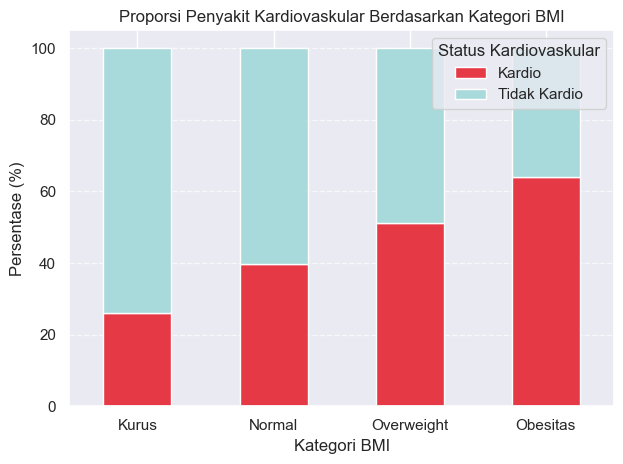

In [54]:
# Hitung BMI
df['BMI'] = df['weight'] / (df['height'] / 100) ** 2

# Klasifikasi kategori BMI
df['BMI_Category'] = pd.cut(df['BMI'],
                            bins=[0, 18.5, 24.9, 29.9, float('inf')],
                            labels=['Kurus', 'Normal', 'Overweight', 'Obesitas'],
                            right=True)

# Cek jumlah pasien per kategori BMI
print(df['BMI_Category'].value_counts())

# Buat crosstab persentase penyakit kardiovaskular per kategori BMI
bmi_cardio = pd.crosstab(df['BMI_Category'], df['cardio'], normalize='index') * 100
bmi_cardio = bmi_cardio.rename(columns={0: 'Tidak Kardio', 1: 'Kardio'})

# Pastikan semua kategori ada, isi 0 jika kosong
bmi_order = ['Kurus', 'Normal', 'Overweight', 'Obesitas']
bmi_cardio = bmi_cardio.reindex(bmi_order, fill_value=0)

# Urutkan kolom supaya 'Kardio' di depan 'Tidak Kardio'
bmi_cardio = bmi_cardio[['Kardio', 'Tidak Kardio']]

# Plot bar stacked
plt.figure(figsize=(8,5))
bmi_cardio.plot(kind='bar', stacked=True, color=['#e63946','#a8dadc'])
plt.title("Proporsi Penyakit Kardiovaskular Berdasarkan Kategori BMI")
plt.xlabel("Kategori BMI")
plt.ylabel("Persentase (%)")
plt.xticks(rotation=0)
plt.legend(title='Status Kardiovaskular')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Proporsi penyakit kardiovaskular meningkat secara signifikan seiring dengan peningkatan kategori Indeks Massa Tubuh (BMI) dari "Kurus" hingga "Obesitas", di mana kategori "Obesitas" memiliki proporsi penyakit tertinggi. BMI sendiri merupakan metrik yang dihitung dari berat badan dan tinggi badan, sehingga tinggi badan juga berkontribusi pada nilai BMI. Meskipun korelasi tinggi badan secara individual dengan penyakit kardiovaskular mungkin sangat kecil, kombinasi berat dan tinggi badan dalam bentuk BMI jelas menunjukkan korelasi yang kuat dengan risiko penyakit jantung, menekankan bahwa tinggi badan secara keseluruhan adalah faktor risiko yang penting.

**10. Bagaimana risiko penyakit berdasarkan usia dan merokok?**

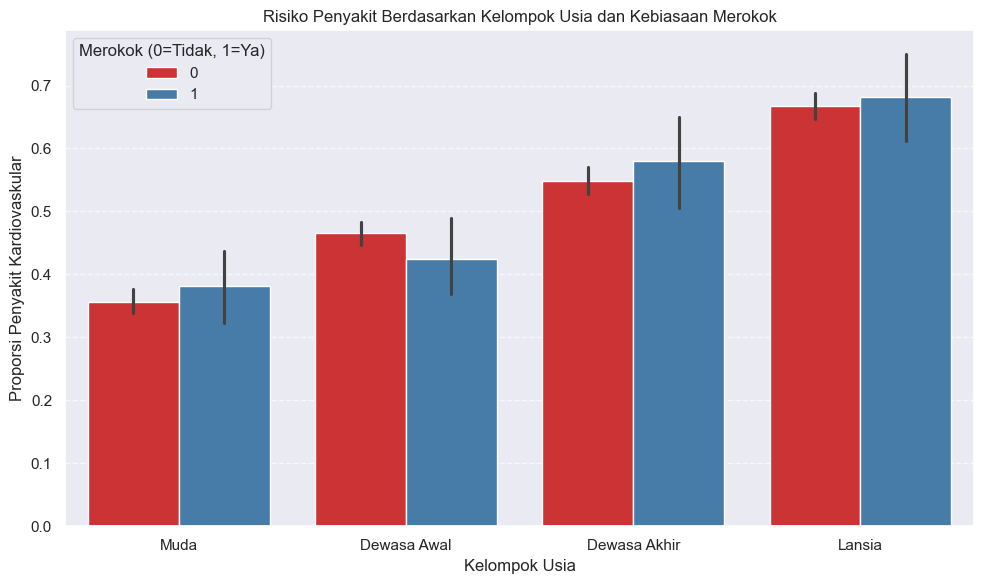

In [55]:
df['age_group'] = pd.qcut(df['age_years'], q=4, labels=['Muda', 'Dewasa Awal', 'Dewasa Akhir', 'Lansia'])

plt.figure(figsize=(10,6))
sns.barplot(data=df, x='age_group', y='cardio', hue='smoke', palette='Set1')
plt.title("Risiko Penyakit Berdasarkan Kelompok Usia dan Kebiasaan Merokok")
plt.xlabel("Kelompok Usia")
plt.ylabel("Proporsi Penyakit Kardiovaskular")
plt.legend(title='Merokok (0=Tidak, 1=Ya)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Risiko penyakit kardiovaskular meningkat seiring bertambahnya usia, di mana kelompok lansia memiliki proporsi penyakit tertinggi. Lebih lanjut, pada hampir setiap kelompok usia, pasien yang merokok memiliki risiko penyakit kardiovaskular yang lebih tinggi dibandingkan non-perokok, menegaskan bahwa merokok memperburuk risiko penyakit jantung, terutama terlihat dampaknya pada usia yang lebih lanjut.

## **Data Preparation** <br>

**Menghapus kolom yang tidak dipakai**

Variabel-variabel dari dataset asli kecuali `id` tidak ada yang dihapus karena berdasarkan Eksplorasi, semua variabel berkontribusi terhadap risiko penyakit kardiovaskular.

In [56]:
# Drop unused column
data = df.drop(columns=['id', 'age_years', 'gluc_level', 'BMI', 'BMI_Category', 'age_group'])

In [57]:
data

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
46730,21770,1,156,64.0,140,80,2,1,0,0,1,1
48393,21876,1,170,85.0,160,90,1,1,0,0,1,1
41416,23270,1,151,90.0,130,80,1,1,0,0,1,1
34506,19741,1,159,97.0,120,80,1,1,0,0,1,1
43725,18395,1,164,68.0,120,80,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
20679,19523,1,157,61.0,120,80,1,1,0,0,1,0
48140,18397,1,157,79.0,145,90,2,1,0,0,1,1
59195,15213,1,156,70.0,100,70,1,1,0,0,1,0
12633,20504,1,158,57.0,120,70,1,1,0,0,1,0


**Menentukan kelompok fitur**

In [58]:
numeric_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
categorical_features = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

In [59]:
target = 'cardio'

**Standardisasi fitur numerik**

In [60]:
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(df[numeric_features])

**Menggabungkan semua fitur**

In [61]:
# Ambil fitur kategorikal tanpa diubah
X_categorical = data[categorical_features].values

# Gabungkan hasil scaling dan kategorikal
X = np.concatenate([X_numeric_scaled, X_categorical], axis=1)

y = data[target].values

**Split data**

In [62]:
# Membagi data menjadi data latih dan data uji (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Modeling** <br>

### Model Multi-Layer Perception(MLP)

In [63]:
# Membuat custom Keras model wrapper
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, optimizer='adam', units=64, batch_size=32, epochs=10):
        self.optimizer = optimizer
        self.units = units
        self.batch_size = batch_size
        self.epochs = epochs

    def build_model(self):
        model = Sequential()
        model.add(Dense(self.units, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))  # untuk klasifikasi biner
        model.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        return model

    def fit(self, X, y):
        self.model = self.build_model()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")


# Membuat model wrapper
model = KerasClassifierWrapper()

# Menentukan parameter grid untuk pencarian
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'units': [32, 64, 128],
    'batch_size': [16, 32],
    'epochs': [10, 50]
}

**Grid Search CV untuk Hyperparameter Optimization**

In [64]:
# Menentukan parameter grid untuk pencarian
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'units': [32, 64, 128],
    'batch_size': [16, 32],
    'epochs': [10, 50]
}

# Melakukan pencarian grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

# Menampilkan hasil pencarian
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step


/Users/macbook/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best: 0.7266253665028556 using {'batch_size': 32, 'epochs': 10, 'optimizer': 'adam', 'units': 128}


**Evaluation Model MLP**

In [31]:
# Mendapatkan model terbaik yang ditemukan oleh GridSearchCV
best_model = grid_result.best_estimator_

# Melakukan prediksi pada data uji
y_pred = best_model.predict(X_test)

# Menilai performa model menggunakan metrik evaluasi
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step
Accuracy: 0.7495
Confusion Matrix:
 [[762 249]
 [252 737]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75      1011
           1       0.75      0.75      0.75       989

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000



### Model TabNet

In [32]:
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_test, y_test)],
    eval_name=['val'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=10,
    batch_size=1024, virtual_batch_size=128
)

/Users/macbook/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72574 | val_accuracy: 0.5175  |  0:00:00s
epoch 1  | loss: 0.6241  | val_accuracy: 0.636   |  0:00:00s
epoch 2  | loss: 0.59974 | val_accuracy: 0.6505  |  0:00:01s
epoch 3  | loss: 0.59432 | val_accuracy: 0.626   |  0:00:01s
epoch 4  | loss: 0.58405 | val_accuracy: 0.6715  |  0:00:01s
epoch 5  | loss: 0.57765 | val_accuracy: 0.703   |  0:00:01s
epoch 6  | loss: 0.57249 | val_accuracy: 0.707   |  0:00:01s
epoch 7  | loss: 0.57492 | val_accuracy: 0.662   |  0:00:01s
epoch 8  | loss: 0.5674  | val_accuracy: 0.7005  |  0:00:02s
epoch 9  | loss: 0.56213 | val_accuracy: 0.6985  |  0:00:02s
epoch 10 | loss: 0.56883 | val_accuracy: 0.7     |  0:00:02s
epoch 11 | loss: 0.56782 | val_accuracy: 0.7005  |  0:00:02s
epoch 12 | loss: 0.56524 | val_accuracy: 0.708   |  0:00:02s
epoch 13 | loss: 0.56151 | val_accuracy: 0.668   |  0:00:03s
epoch 14 | loss: 0.55928 | val_accuracy: 0.712   |  0:00:03s
epoch 15 | loss: 0.56075 | val_accuracy: 0.7055  |  0:00:03s
epoch 16 | loss: 0.55516

/Users/macbook/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


**Evaluation Model TabNet**

In [33]:
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7225
Confusion Matrix:
 [[796 215]
 [340 649]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.79      0.74      1011
           1       0.75      0.66      0.70       989

    accuracy                           0.72      2000
   macro avg       0.73      0.72      0.72      2000
weighted avg       0.73      0.72      0.72      2000



## **Kesimpulan** <br>

**Model MLP**
- Akurasi sebesar 0.7495 (≈ 74.95%). Akurasi 75% menunjukkan bahwa model bisa mengklasifikasikan 3 dari 4 data dengan benar.
- Karena nilai precision, recall, dan F1-score untuk kedua kelas hampir identik (semua 0.75), artinya model ini cukup seimbang dalam mengenali kelas 0 dan kelas 1.
- Berdasarkan Confusion Matrix didapatkan kelas 0 (Negatif) sebesar 762 benar, 249 salah dan kelas 1 (Positif) sebesar 737 benar, 252 salah.

**Model TabNet**
- Akurasi sebesar 0.7225 (≈ 72.25%). 
- Berdasarkan Confusion Matrix didapatkan kelas 0 (Negatif) sebesar 796 benar, 215 salah dan kelas 1 (Positif) sebesar 649 benar, 340 salah
- Recall kelas 1 hanya 0.66, artinya banyak kasus positif yang tidak terdeteksi (False Negative tinggi: 340).
- Precision kelas 1 cukup tinggi (0.75), artinya kalau model bilang “positif”, cukup bisa dipercaya. 
- F1-score untuk kelas 1 adalah 0.70 (dibanding 0.75 di MLP), menandakan trade-off precision vs recall-nya tidak sebaik MLP.


**Kesimpulan:** <br>
Berdasarkan hasil evaluasi kedua model, **MLP dipilih sebagai model terbaik** karena memiliki performa yang lebih baik secara keseluruhan dibandingkan TabNet. MLP menunjukkan akurasi yang lebih tinggi (74.95% vs 72.25%), serta metrik evaluasi seperti precision, recall, dan F1-score yang lebih seimbang antar kelas. Sementara TabNet cenderung memiliki recall yang rendah pada kelas positif, yang dapat berisiko tinggi apabila klasifikasi positif bersifat krusial. Oleh karena itu, model MLP lebih layak digunakan untuk deployment dalam proyek ini.

## **Save Model** <br>

In [66]:
# Simpan model terbaik ke dalam folder 
best_model.model.save("IllDetect_Capstone_Project_ML/model_best.h5")

In [67]:
!tensorflowjs_converter --input_format=keras IllDetect_Capstone_Project_ML/model_best.h5 IllDetect_Capstone_Project_ML/tfjs_model

🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


## **Inferensi** <br>

In [65]:
# Data baru yang akan diprediksi
new_data_dict = {
    'age': 20440,
    'gender': 1,
    'height': 156,
    'weight': 85,
    'ap_hi': 140,
    'ap_lo': 90,
    'cholesterol': 3,
    'gluc': 1,
    'smoke': 0,
    'alco': 0,
    'active': 1
}

# Daftar fitur numerik dan kategorikal, pastikan urutannya sama seperti saat training
numeric_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
categorical_features = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

# Siapkan input data sesuai urutan
numeric_input = np.array([[new_data_dict[feat] for feat in numeric_features]])  # (1, 5)
categorical_input = np.array([[new_data_dict[feat] for feat in categorical_features]])  # (1, 6)

# Scaling fitur numerik
numeric_scaled = scaler.transform(numeric_input)  # (1, 5)

# Gabungkan numerik dan kategorikal jadi satu array
X_new = np.concatenate([numeric_scaled, categorical_input], axis=1).astype(np.float32)  # (1, 11)

# Prediksi (model output bentuknya sudah (n,) karena flatten() di predict())
y_pred = best_model.predict(X_new)  # hasil akhir berupa array isi 0 atau 1
y_proba = best_model.model.predict(X_new)  # probabilitas asli dari sigmoid

# Output
print("Prediksi risiko (0 = tidak, 1 = risiko):", int(y_pred[0]))
print("Probabilitas risiko:", y_proba[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step

/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Prediksi risiko (0 = tidak, 1 = risiko): 1
Probabilitas risiko: 0.8823761


/var/folders/m2/f0dmk8qn71593x9d7n6nlxl00000gn/T/ipykernel_3176/723445391.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Prediksi risiko (0 = tidak, 1 = risiko):", int(y_pred[0]))
